In [1]:
figDir = '~/Hyphosphere/data/3Exp/figures'

#work_dir = '~/Hyphosphere/data/3Exp/Composition'

# phyloseq - full object with tree (does not include archaea)
physeq_file = '~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_wtree_experimental_woContam.rds'

In [2]:
library(RColorBrewer)
library(vegan)
library(tidyr)
library(dplyr)
library(reshape2)
library(phyloseq)
library(gridExtra)
library(ggplot2)
library(foreach)
library(doParallel)

Warning message:
“package ‘RColorBrewer’ was built under R version 3.6.1”Warning message:
“package ‘vegan’ was built under R version 3.6.1”Loading required package: permute
Warning message:
“package ‘permute’ was built under R version 3.6.1”Loading required package: lattice
Warning message:
“package ‘lattice’ was built under R version 3.6.1”This is vegan 2.5-5
Registered S3 method overwritten by 'dplyr':
  method               from  
  as.data.frame.tbl_df tibble

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘reshape2’ was built under R version 3.6.1”
Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Warning message:
“package ‘phyloseq’ was built under R version 3.6.1”
Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

In [3]:
theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

In [4]:
ps = readRDS(physeq_file)
ps = subset_taxa(ps, !is.na("Phylum"))


tax_table(ps) %>% head()
ps = subset_taxa(ps, Kingdom == "Bacteria" &  !is.na(Phylum))
ps = subset_samples(ps, !SampleType %in% c("EB", "PB", "MK")) #remove non-experimental controls

# re-normalize after subsetting taxa
ps.snorm = transform_sample_counts(ps, function(x) x/sum(x))

otu_table(ps.snorm)[1:4, 1:10]
tax_table(ps.snorm) %>% tail()

ps.snorm
                                  


,Kingdom,Phylum,Class,Order,Family,Genus
ASV5742,Bacteria,NA,NA,NA,NA,NA
ASV6971,Bacteria,NA,NA,NA,NA,NA
ASV2480,Bacteria,NA,NA,NA,NA,NA
ASV15180,Bacteria,Acidobacteria,Subgroup_20,NA,NA,NA
ASV9985,Bacteria,Acidobacteria,Subgroup_20,NA,NA,NA
ASV22021,Bacteria,Acidobacteria,Subgroup_20,NA,NA,NA


,ASV15180,ASV9985,ASV22021,ASV9417,ASV23617,ASV15142,ASV7191,ASV3993,ASV6463,ASV11356
1.1BP,0,0,0.0001437286,0,0,0,0,0,0.0002235779,0
1.1BS,0,0,0.0000000000,0,0,0,0,0,0.0000000000,0
1.1CH,0,0,0.0000000000,0,0,0,0,0,0.0000000000,0
1.1CS,0,0,0.0000000000,0,0,0,0,0,0.0000000000,0


,Kingdom,Phylum,Class,Order,Family,Genus
ASV12734,Bacteria,Nitrospirae,Nitrospira,Nitrospirales,Nitrospiraceae,Nitrospira
ASV7856,Bacteria,Nitrospirae,Nitrospira,Nitrospirales,Nitrospiraceae,Nitrospira
ASV6750,Bacteria,Nitrospirae,Nitrospira,Nitrospirales,Nitrospiraceae,Nitrospira
ASV25727,Bacteria,Nitrospirae,Nitrospira,Nitrospirales,Nitrospiraceae,Nitrospira
ASV12882,Bacteria,Nitrospirae,Nitrospira,Nitrospirales,Nitrospiraceae,Nitrospira
ASV1743,Bacteria,Nitrospirae,Nitrospira,Nitrospirales,Nitrospiraceae,Nitrospira


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14996 taxa and 385 samples ]
sample_data() Sample Data:       [ 385 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 14996 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14996 tips and 14995 internal nodes ]

# Experiment 1 & 2 primary analysis

In [5]:
ps.s = ps.snorm %>% subset_samples(Experiment %in% c(1, 2) & SampleType %in% c("CS", "CH", "BS") & Fungus == "Gv")

In [6]:
registerDoParallel(makeCluster(20))

In [7]:
wunif.dist = phyloseq::distance(ps.s, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#unif.dist = phyloseq::distance(ps.snorm, 
#                       method = "unifrac", 
#                       weighted = FALSE,
#                       fast = TRUE, 
#                       parallel = TRUE, 
#                       normalized = FALSE)

In [8]:
set.seed(101)

df = as(sample_data(ps.s), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = wunif.dist

adonis.w = adonis(formula = d ~Soil + SampleType + SampleType:Soil + Experiment + Experiment:SampleType, df, permutations = 999)
print("weighted-UniFrac")
adonis.w

[1] "weighted-UniFrac"



Call:
adonis(formula = d ~ Soil + SampleType + SampleType:Soil + Experiment +      Experiment:SampleType, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Soil                   3    1.7221 0.57404 23.0972 0.29452  0.001 ***
SampleType             2    1.4377 0.71885 28.9242 0.24588  0.001 ***
Experiment             1    0.2948 0.29481 11.8623 0.05042  0.001 ***
Soil:SampleType        5    0.5202 0.10403  4.1859 0.08896  0.001 ***
SampleType:Experiment  1    0.1078 0.10782  4.3383 0.01844  0.003 ** 
Residuals             71    1.7646 0.02485         0.30178           
Total                 83    5.8472                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

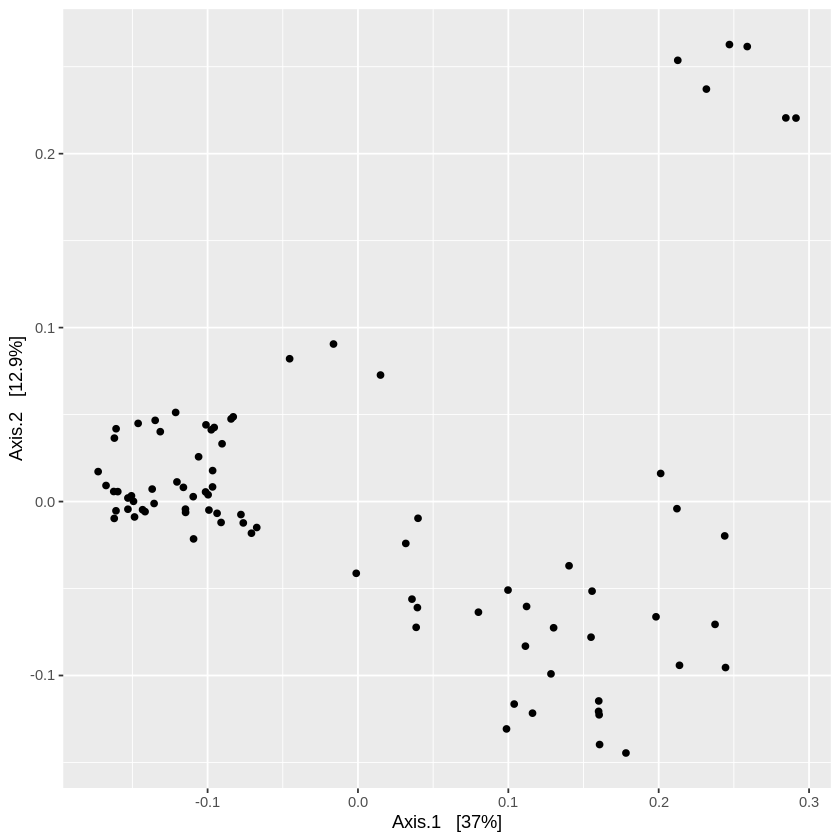

In [9]:
ordu = ordinate(ps.s, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.s, ordu, justDF = TRUE)
plot_ordination(ps.s, ordu)

png 
  2

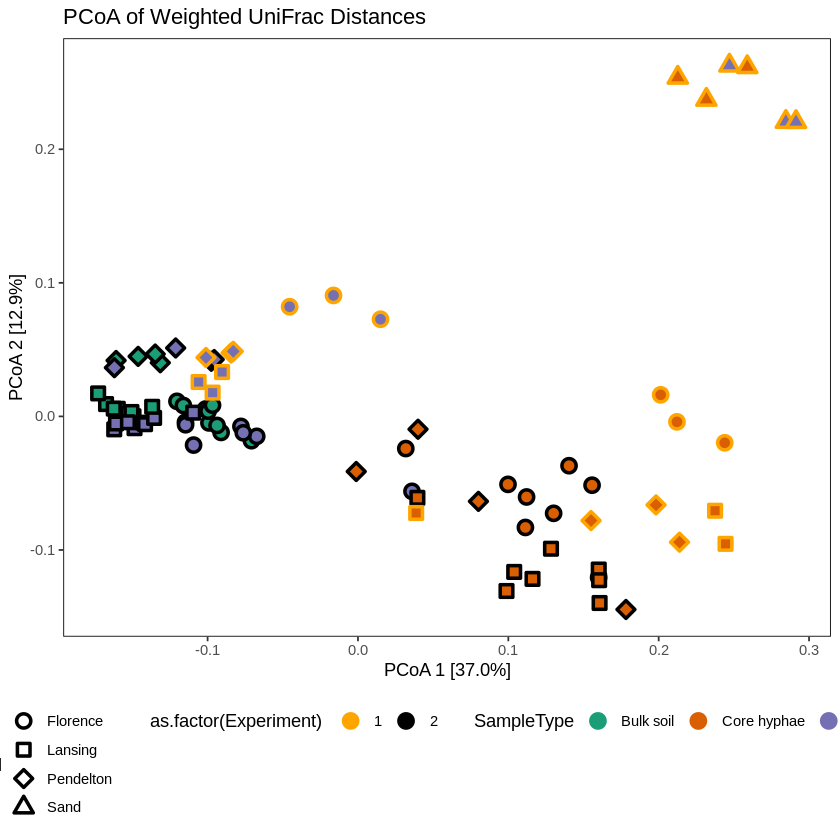

In [12]:
#setwd(figDir)
cs = brewer.pal(3,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(Soil), fill = SampleType, color = as.factor(Experiment)),  size = 3, stroke = 1.5) +
theme_pub() +
scale_shape_manual(values=c(21,22,23,24), guide = guide_legend(title = "Soil", ncol = 1))+
scale_color_manual(values=c('Orange','Black'))+
scale_fill_manual(values = cs, labels = c("Bulk soil", "Core hyphae", "Core slurry"))+
labs(x = "PCoA 1 [37.0%]", y = "PCoA 2 [12.9%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+
#facet_wrap(~Experiment, ncol = 2)

guides(fill=guide_legend(override.aes=list(colour= cs), ncol = 3)) + 
theme(legend.position="bottom") 

#color = "grey20",

p1

pdf(file.path(figDir,"Exp1-2_wUnif_PCOA_BSCHCS.pdf"), useDingbats = FALSE, width = 4.5, height = 4.5)
p1
dev.off()

## Ordinate hyphal and soil samples and include Rib
* This is not particularly helpful, better to proceed with focused comparison

In [13]:
ps.s = ps.snorm %>% subset_samples(Experiment %in% c(1, 2) & SampleType %in% c("CS", "CH", "BS"))

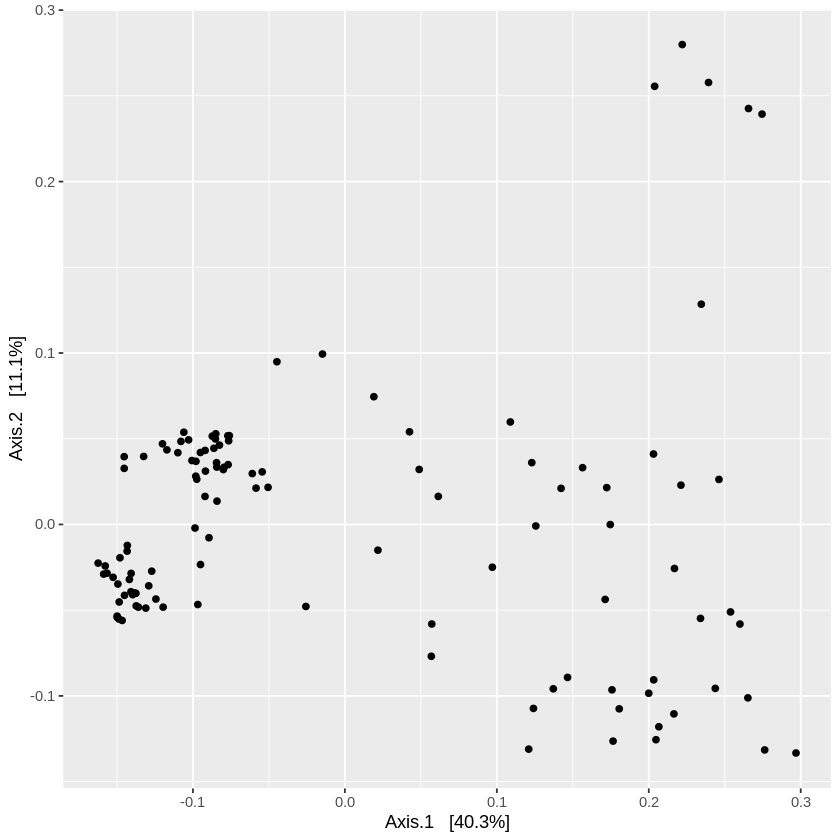

In [14]:
ordu = ordinate(ps.s, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.s, ordu, justDF = TRUE)
plot_ordination(ps.s, ordu)

NULL

png 
  2

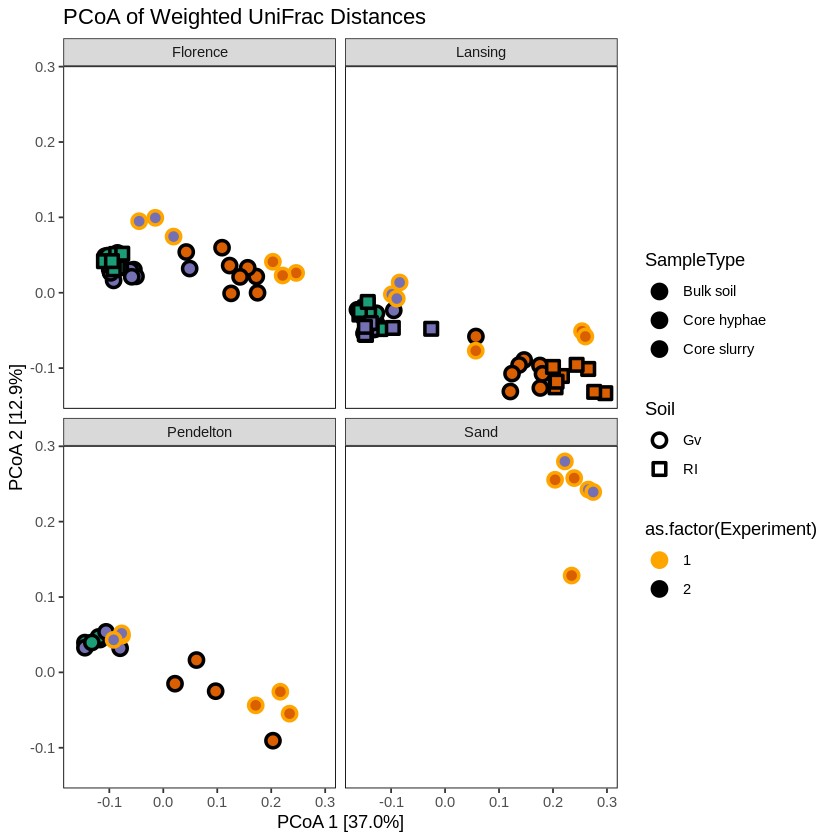

In [16]:
#setwd(figDir)
cs = brewer.pal(3,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(Fungus), fill = SampleType, color = as.factor(Experiment)),  size = 3, stroke = 1.5) +
theme_pub() +
scale_shape_manual(values=c(21,22,23,24), guide = guide_legend(title = "Soil", ncol = 1))+
scale_color_manual(values=c('Orange','Black'))+
scale_fill_manual(values = cs, labels = c("Bulk soil", "Core hyphae", "Core slurry"))+
labs(x = "PCoA 1 [37.0%]", y = "PCoA 2 [12.9%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+
facet_wrap(~Soil, ncol = 2)

guides(fill=guide_legend(override.aes=list(colour= cs), ncol = 3)) + 
theme(legend.position="bottom") 

#color = "grey20",

p1

pdf(file.path(figDir,"Exp1-2_wUnif_PCOA_BSCHCS.pdf"), useDingbats = FALSE, width = 4.5, height = 4.5)
p1
dev.off()

# Subset to just bulk soils and hyphal soils

In [17]:
ps.b = subset_samples(ps.snorm, SampleType %in% c("BS", "BH"))

In [18]:
b.wunif.dist = phyloseq::distance(ps.b, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                                  
                      normalized = FALSE)

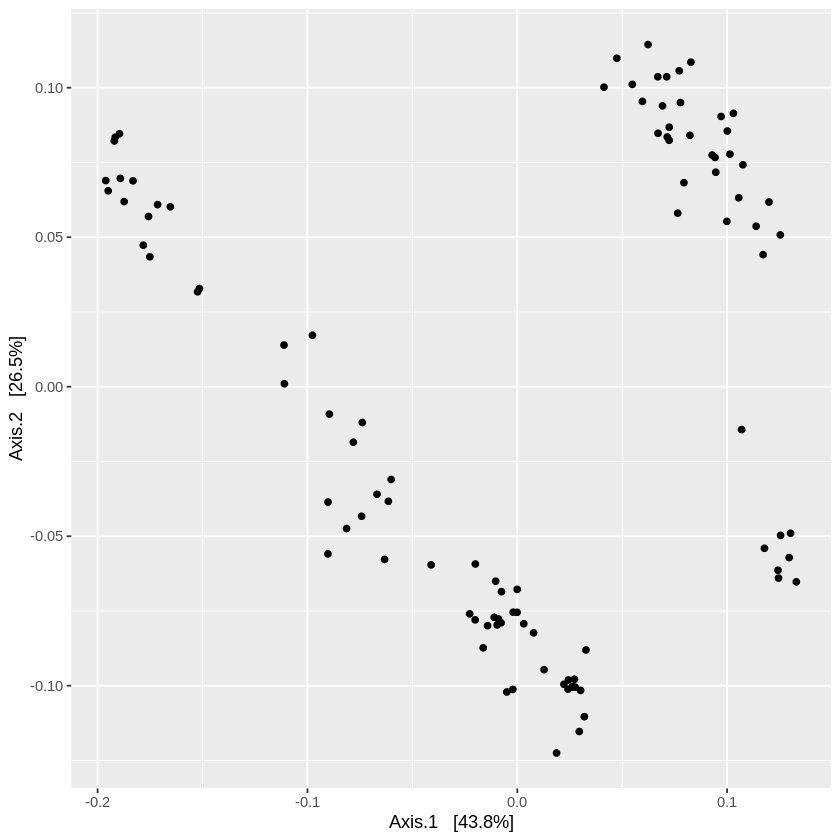

In [19]:
ordu = ordinate(ps.b, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.b, ordu, justDF = TRUE)
plot_ordination(ps.snorm, ordu)

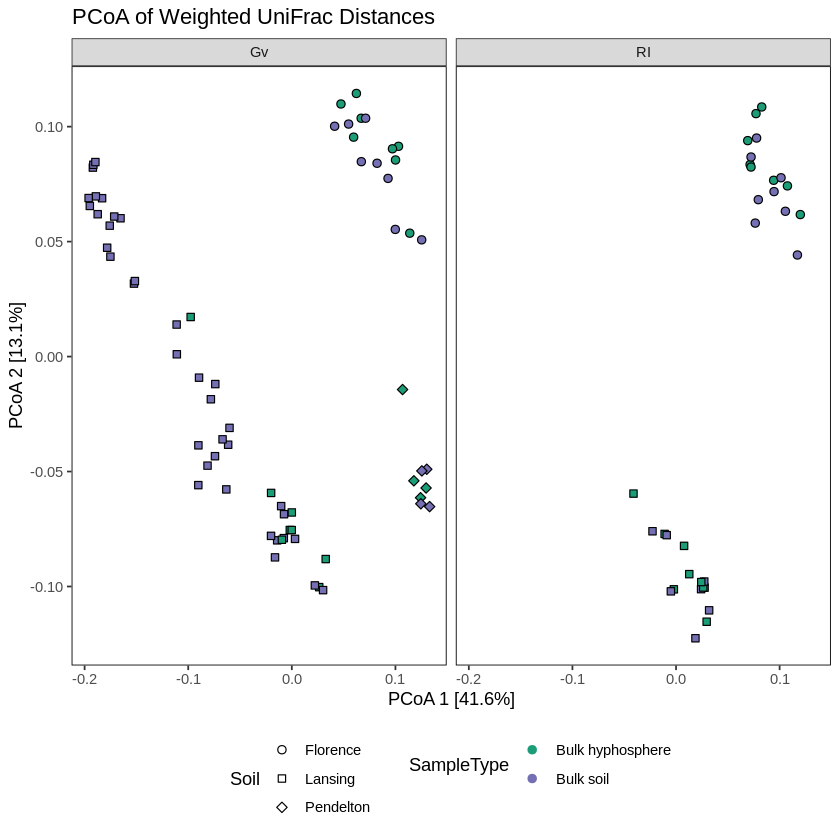

In [20]:
#setwd(figDir)
cs = brewer.pal(7,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(Soil), fill = SampleType),  size = 2) +
theme_pub() +
scale_shape_manual(values=c(21,22,23), guide = guide_legend(title = "Soil", ncol = 1))+
scale_fill_manual(values = cs[c(1,3)], labels = c("Bulk hyphosphere", "Bulk soil"))+
labs(x = "PCoA 1 [41.6%]", y = "PCoA 2 [13.1%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+

guides(fill=guide_legend(override.aes=list(colour= cs[c(1,3)]), ncol = 1)) + 
theme(legend.position="bottom") +
facet_wrap(~Fungus, ncol = 2)

#color = "grey20",

p1

#pdf(file.path(figDir,"wUnif_PCOA_BSBH.pdf"), useDingbats = FALSE, width = 4.5, height = 3)
#p1
#dev.off()

In [105]:
set.seed(101)

df = as(sample_data(ps.b), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = b.wunif.dist

b.adonis.w = adonis(formula = d ~ Rep + Soil + SampleType + Soil:SampleType + Fungus + Fungus:SampleType, df, permutations = 999)
print("weighted-UniFrac")
b.adonis.w

# d = unif.dist
# #Soiladonis = adonis(formula = d ~ Planted + DAP + Plant + Treatment, df, strata = df$Rep:df$Plant, permutations = 999)
# adonis.u = adonis(formula = d ~ Rep + SampleType + TimePoint + SampleType:TimePoint, df, permutations = 999)
# print("unweighted-UniFrac")
#adonis.u

[1] "weighted-UniFrac"



Call:
adonis(formula = d ~ Rep + Soil + SampleType + Soil:SampleType +      Fungus + Fungus:SampleType, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                  Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep                1  0.001013 0.0010131   3.571 0.02216  0.007 ** 
Soil               2  0.024764 0.0123818  43.644 0.54161  0.001 ***
SampleType         1  0.000350 0.0003500   1.234 0.00765  0.229    
Fungus             1  0.000275 0.0002749   0.969 0.00601  0.367    
Soil:SampleType    2  0.000408 0.0002040   0.719 0.00892  0.708    
SampleType:Fungus  1  0.000189 0.0001889   0.666 0.00413  0.667    
Residuals         66  0.018724 0.0002837         0.40951           
Total             74  0.045723                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# Does fungal species matter

In [41]:
ps.s = subset_samples(ps.snorm, SampleType %in% c("BS","CS","CH") & Soil == "Lansing" & Experiment == 2)

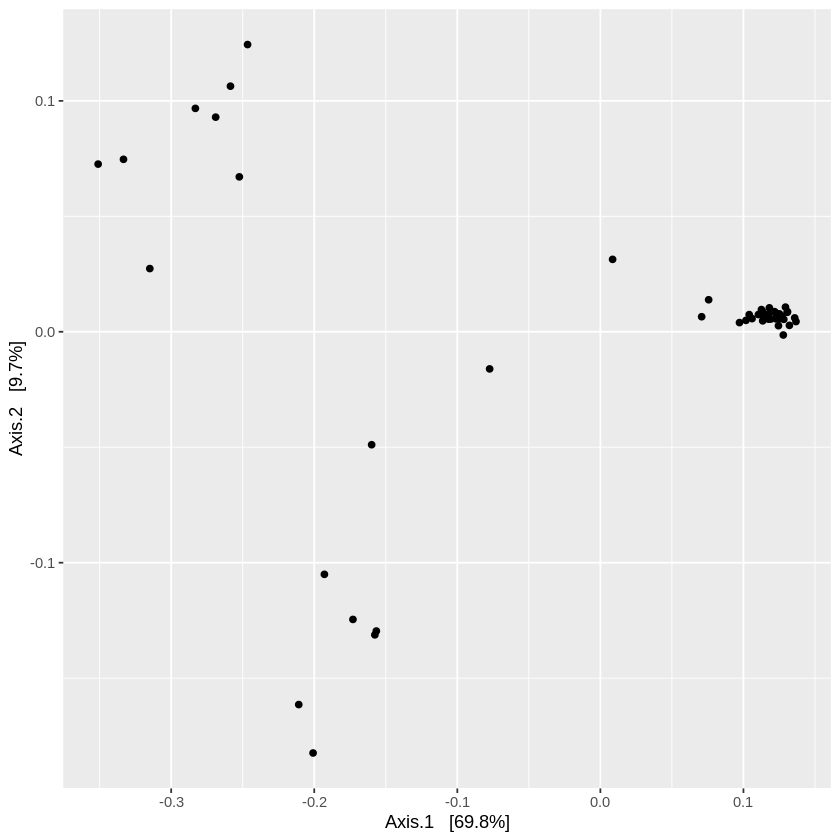

In [42]:
ordu = ordinate(ps.s, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.b, ordu, justDF = TRUE)
plot_ordination(ps.snorm, ordu)

In [ ]:
geom_point(aes(shape = as.factor(Soil), fill = SampleType, color = as.factor(Experiment)),  size = 3, stroke = 1.5) +
theme_pub() +
scale_shape_manual(values=c(21,22,23,24), guide = guide_legend(title = "Soil", ncol = 1))+
scale_color_manual(values=c('Orange','Black'))+
scale_fill_manual(values = cs, labels = c("Bulk soil", "Core hyphae", "Core slurry"))+

png 
  2

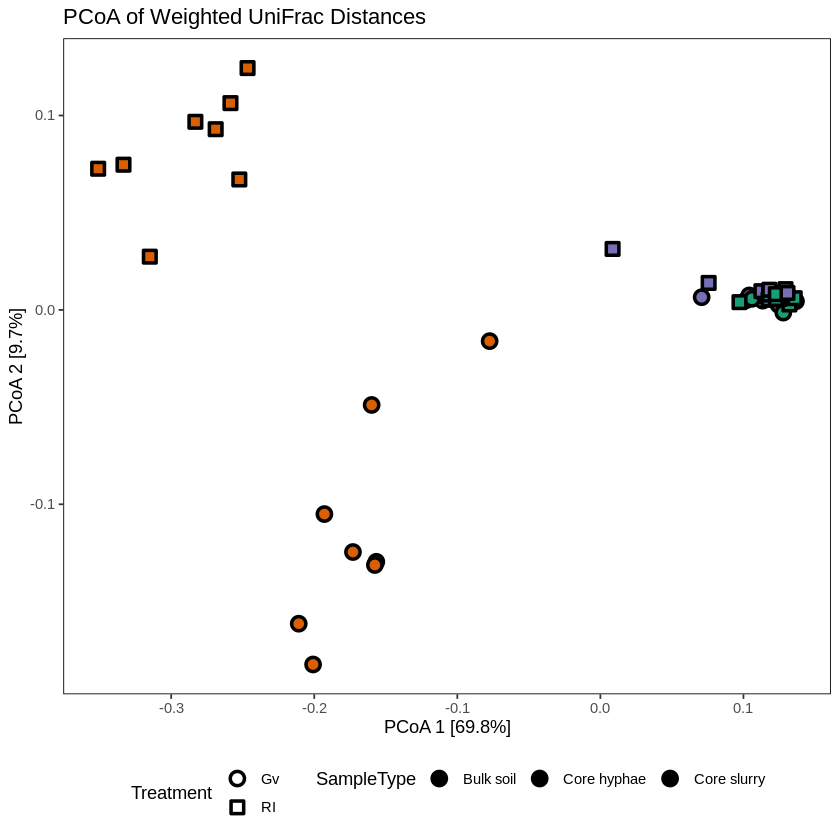

In [40]:
cs = brewer.pal(3,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(Fungus), fill = SampleType),  size = 3, stroke = 1.5) +
theme_pub() +
scale_shape_manual(values=c(21,22), guide = guide_legend(title = "Treatment", ncol = 1))+
scale_fill_manual(values = cs, labels = c("Bulk soil", "Core hyphae", "Core slurry"))+
labs(x = "PCoA 1 [69.8%]", y = "PCoA 2 [9.7%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+

#guides(fill=guide_legend(override.aes=list(colour= cs[c(4,6)]), ncol = 1)) + 
theme(legend.position="bottom")

#color = "grey20",

p1

pdf(file.path(figDir,"wUnif_PCOA_CHCSxFungus.pdf"), useDingbats = FALSE, width = 6, height = 4)
p1
dev.off()

In [43]:
s.wunif.dist = phyloseq::distance(ps.s, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [44]:
### set.seed(101)

df = as(sample_data(ps.b), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = s.wunif.dist

s.adonis.w = adonis(formula = d ~ as.factor(Rep) + SampleType + Fungus + Fungus:SampleType, df, permutations = 999)
print("weighted-UniFrac")
s.adonis.w

[1] "weighted-UniFrac"



Call:
adonis(formula = d ~ as.factor(Rep) + SampleType + Fungus + Fungus:SampleType,      data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                  Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
as.factor(Rep)     3   0.07831 0.02610   2.863 0.03454  0.021 *  
SampleType         2   1.51842 0.75921  83.273 0.66971  0.001 ***
Fungus             1   0.11381 0.11381  12.483 0.05020  0.001 ***
SampleType:Fungus  2   0.20118 0.10059  11.033 0.08873  0.001 ***
Residuals         39   0.35557 0.00912         0.15683           
Total             47   2.26729                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# Just core hyphae, treatment effects

Warning message in matrix(tree$edge[order(tree$edge[, 1]), ][, 2], byrow = TRUE, :
“data length [25449] is not a sub-multiple or multiple of the number of rows [12725]”

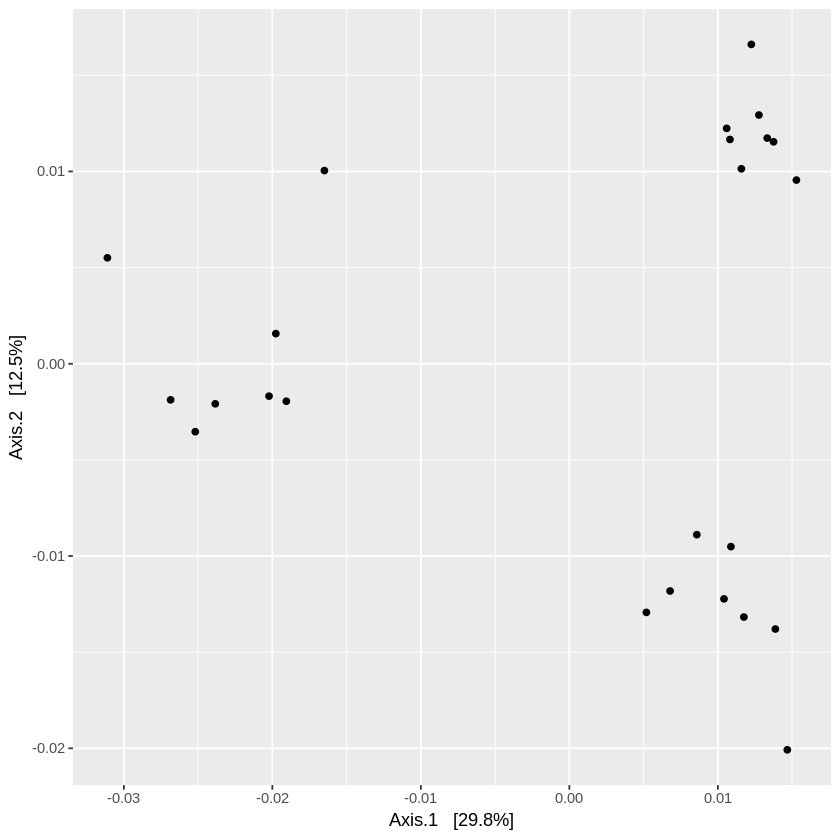

In [167]:
ps.b = subset_samples(ps.snorm, SampleType %in% c("CH") & Soil != "Pendelton")
ordu = ordinate(ps.b, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(ps.b, ordu, justDF = TRUE)
plot_ordination(ps.snorm, ordu)

png 
  2

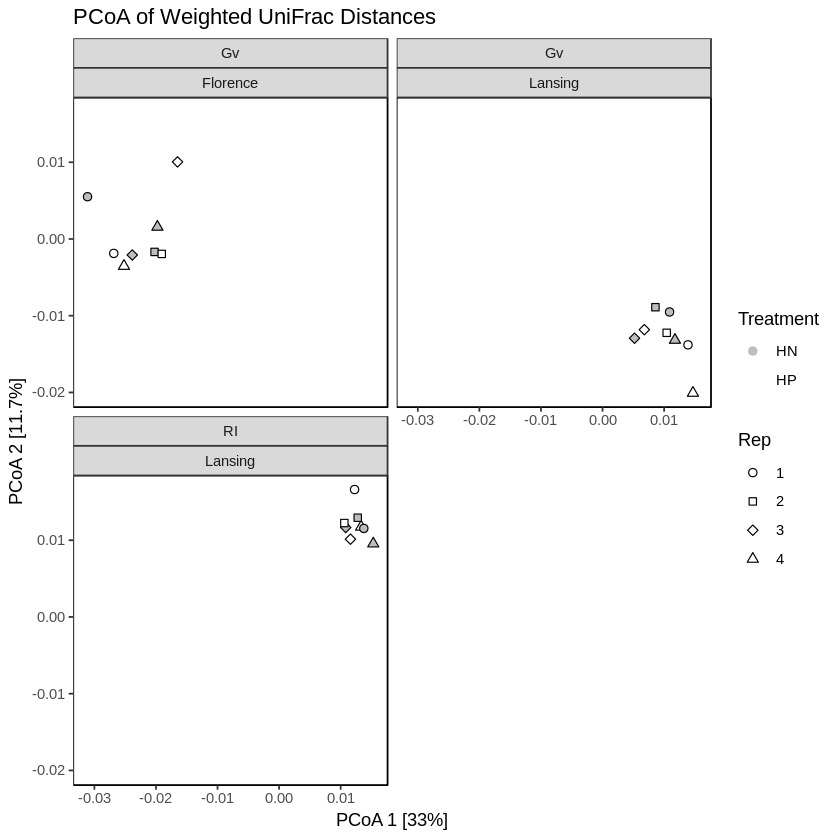

In [173]:
cs = brewer.pal(7,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(Rep), fill = Treatment),  size = 2) +
theme_pub() +
scale_shape_manual(values=c(21,22,23,24), guide = guide_legend(title = "Rep", ncol = 1))+
scale_fill_manual(values = c("Grey", "White"))+
labs(x = "PCoA 1 [33%]", y = "PCoA 2 [11.7%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+

guides(fill=guide_legend(override.aes=list(color= c("Grey", "White")), ncol = 1)) + 
theme(legend.position="right") +
facet_wrap(Fungus~Soil, ncol = 2)

#color = "grey20",

p1

pdf(file.path(figDir,"wUnif_PCOA_CHxTreatment.pdf"), useDingbats = FALSE, width = 4.5, height = 3.5)
p1
dev.off()

In [174]:
b.wunif.dist = phyloseq::distance(ps.b, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Warning message in matrix(tree$edge[order(tree$edge[, 1]), ][, 2], byrow = TRUE, :
“data length [25449] is not a sub-multiple or multiple of the number of rows [12725]”

In [175]:
df = as(sample_data(ps.b), "data.frame")
#df$Rep = as.factor(df$Rep)
#df$TimePoint = as.factor(df$TimePoint)
d = b.wunif.dist

b.adonis.w = adonis(formula = d ~ as.factor(Rep) + Soil + Fungus + Treatment + Treatment:Fungus + Treatment:Soil, df, permutations = 999)
print("weighted-UniFrac")
b.adonis.w

[1] "weighted-UniFrac"



Call:
adonis(formula = d ~ as.factor(Rep) + Soil + Fungus + Treatment +      Treatment:Fungus + Treatment:Soil, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                 Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
as.factor(Rep)    3 0.0030367 0.0010122  1.3979 0.11577  0.089 .  
Soil              1 0.0076001 0.0076001 10.4960 0.28974  0.001 ***
Fungus            1 0.0030116 0.0030116  4.1591 0.11481  0.001 ***
Treatment         1 0.0006460 0.0006460  0.8921 0.02463  0.496    
Fungus:Treatment  1 0.0003912 0.0003912  0.5403 0.01492  0.971    
Soil:Treatment    1 0.0006837 0.0006837  0.9443 0.02607  0.433    
Residuals        15 0.0108614 0.0007241         0.41407           
Total            23 0.0262308                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1